In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.ensemble import RandomForestClassifier

### Import & Preprocessing

In [8]:
df = pd.read_csv("heart_disease_prediction.csv")
df = df.rename({'Heart Disease': 'Y'}, axis=1) 
df["Y"].replace({'Absence' : int(0), "Presence" : int(1)}, inplace=True, regex=True)
y = df.values[:,-1].astype(int)
X = df.drop("Y", axis=1)

df.head(10)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Y
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0
5,65,1,4,120,177,0,0,140,0,0.4,1,0,7,0
6,56,1,3,130,256,1,2,142,1,0.6,2,1,6,1
7,59,1,4,110,239,0,2,142,1,1.2,2,1,7,1
8,60,1,4,140,293,0,2,170,0,1.2,2,2,7,1
9,63,0,4,150,407,0,2,154,0,4.0,2,3,7,1


### Feature selection & Feature Examination

In [9]:
scaler = MinMaxScaler()
df_norm = X
df_norm[list(X)] = scaler.fit_transform(df[list(X)])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

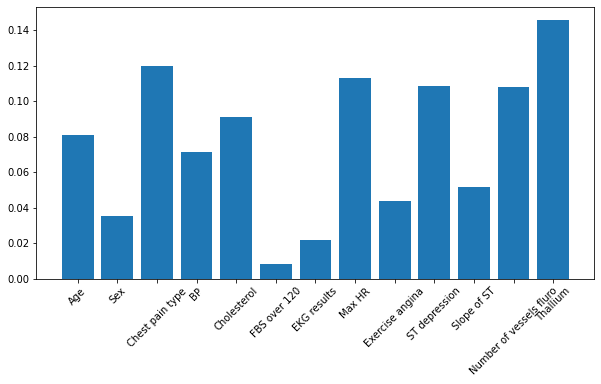

In [10]:
clf = RandomForestClassifier()
clf.fit(df_norm, y)
plt.figure(figsize=(10,5))
plt.bar(df_norm.columns, clf.feature_importances_)
plt.xticks(rotation=45)

### Solution Implementation

In [20]:
# Let's say we have 4 features: x1, x2, x3, x4
# 1. Function which returns all the possible combinations: E.g.: For 3 features: (x1, x2), (x2, x3), (x1, x3), (x1, x2, x3).
# 2. We Iterate through this list, and for each, we try to find the best oversampler (augmentation method) out of 5-10 oversamplers.
# 2/1. Get the 5 best oversampler for the given dataset.
# 2/2. Try to run 5 oversampler from an array.
# 2/3. Get columns with values
# 2/4. Measure accuracy and score
# 2/5. Later implement new accuracy measures?
# 3. We run RandomForestClassifier and for each itertation, we save the rankings of the features based on importance.
# 3.2. Upon validation we take the same subsets of the validation set!
# 4. Write our own evaulation method: Take the rankings and select the top 3 features (and the best oversampler.)

In [27]:
# 1. Function which returns all the possible combinations: E.g.: For 3 features: (x1, x2), (x2, x3), (x1, x3), (x1, x2, x3).
import itertools
import random

feature_set = df_norm.columns
# Min: 2, Max: 13
MIN = 4 #4
MAX = 5 #9

#Remove this line for proper results
feature_set = random.sample(list(feature_set), MAX)

combinations = []
for L in range(MIN, len(feature_set) + 1):
    for subset in itertools.combinations(feature_set, L):
        combinations.append(subset)
        print(subset)
print(len(combinations))

('Thallium', 'EKG results', 'Sex', 'Slope of ST')
('Thallium', 'EKG results', 'Sex', 'Age')
('Thallium', 'EKG results', 'Slope of ST', 'Age')
('Thallium', 'Sex', 'Slope of ST', 'Age')
('EKG results', 'Sex', 'Slope of ST', 'Age')
('Thallium', 'EKG results', 'Sex', 'Slope of ST', 'Age')
6


In [12]:
# 2/1. Get the 5 best oversampler for the given dataset.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import shutil
import smote_variants as sv
import time

start = time.time()
print("Starting timer")

def handle_chace():
    cache_path = os.path.join(os.path.expanduser('~'), 'smote_tests\smote_test')
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    else:
        shutil.rmtree(cache_path)
    return cache_path

best_5_oversampler = [sv._smote_variants.Borderline_SMOTE1, sv._smote_variants.SPY, sv._smote_variants.Gaussian_SMOTE, sv._smote_variants.SL_graph_SMOTE, sv._smote_variants.SMOTE_TomekLinks]
"""
#This procedure takes approximately 3+ minutes to continue. For the heart_disease dataset, the best 5 oversamplers are the hardcoded ones.

# Selecting the top 5 oversampler
# It is basically brute force so its computation intensive!
oversamplers = sv.get_n_quickest_oversamplers(30)
best_5_oversampler = []

for attempt in range(0, 5):
    cache_path = handle_chace()
    # samp_obj and cl_obj contain the oversampling and classifier objects which give the best performance together
    samp_obj, cl_obj = sv.model_selection(dataset= {'data': df_norm.values, 'target': y, 'name': 'heart_disease_data'},
                                            samplers= oversamplers,
                                            classifiers= [KNeighborsClassifier(), DecisionTreeClassifier()],
                                            cache_path= cache_path,
                                            n_jobs= 5,
                                            max_samp_par_comb= 35)
    best_5_oversampler.append(samp_obj)
    oversamplers.remove(type(samp_obj))
"""
end = time.time()
print("Elapsed time: ", end - start, " seconds")

Starting timer
Elapsed time:  0.0010068416595458984  seconds


In [13]:
print(best_5_oversampler)
#best_5_oversampler = [sv._smote_variants.Borderline_SMOTE1, sv._smote_variants.SPY, sv._smote_variants.Gaussian_SMOTE, sv._smote_variants.SL_graph_SMOTE, sv._smote_variants.SMOTE_TomekLinks]
best_5_oversampler = [sv._smote_variants.Borderline_SMOTE1, sv._smote_variants.SPY, sv._smote_variants.Gaussian_SMOTE]
best_5_oversampler

[<class 'smote_variants._smote_variants.Borderline_SMOTE1'>, <class 'smote_variants._smote_variants.SPY'>, <class 'smote_variants._smote_variants.Gaussian_SMOTE'>, <class 'smote_variants._smote_variants.SL_graph_SMOTE'>, <class 'smote_variants._smote_variants.SMOTE_TomekLinks'>]


[smote_variants._smote_variants.Borderline_SMOTE1,
 smote_variants._smote_variants.SPY,
 smote_variants._smote_variants.Gaussian_SMOTE]

In [28]:
# For each of the substes we try to find the best oversampler (out of the top 5)
# 2/2. Try to run 5 oversampler from an array.
# 2/3. Get columns with values

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import shutil
import smote_variants as sv
import time
import pprint

start = time.time()

# *Option 1*: For every combination, i check which one is the best classifier out of the 5, and rank the importances (set: best rank 1, worst: n)
# Option 2: For every oversampler (5) i run all the combinations, and rank the importances (set: best rank 1, worst: n)
output = []
for combination in combinations:
    cache_path = handle_chace()

    X_train, X_test, y_train, y_test = train_test_split(df_norm[list(combination)].values, y, test_size= 0.25, random_state= 0)
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    original_score = clf.score(X_test, y_test)
    #cross_val_score(clf, X_test, y_test, scoring= 'accuracy', cv= RepeatedStratifiedKFold(n_splits= 5, n_repeats= 3, random_state= 1), n_jobs= -1)
    original_feature_importance = clf.feature_importances_


    dataset= {'data': X_train, 'target': y_train, 'name': 'heart_disease_data2'}
    samp_obj, cl_obj = sv.model_selection(dataset= dataset,
                                samplers= best_5_oversampler,
                                classifiers= [KNeighborsClassifier(), DecisionTreeClassifier()],
                                cache_path= cache_path,
                                n_jobs= 5,
                                max_samp_par_comb= 35)

    X_samp, y_samp = samp_obj.sample(dataset['data'], dataset['target'])
    print(len(X_train), " - ", len(X_samp))

    clf = RandomForestClassifier()
    clf.fit(X_samp, y_samp)
    score = clf.score(X_test, y_test)
    #cross_val_score(clf, X_test, y_test, scoring= 'accuracy', cv= RepeatedStratifiedKFold(n_splits= 5, n_repeats= 3, random_state= 1), n_jobs= -1)

    feature_importance = clf.feature_importances_

    #TODO delta = set by the user, minimum differece between the two sets
    delta = 0.02
    if round(original_score, 5) + delta < round(score, 5):
        output.append(
            {
                "combination" : combination, 
                "sampler": type(samp_obj),
                "original_feature_importance": original_feature_importance,
                "feature_importance": feature_importance,
                "original_score": round(original_score, 3),
                "score": round(score, 3)
            })
pprint.pprint(output)

end = time.time()
print("Elapsed time: ", end - start, " seconds, which is: ", (end - start) / 60, " minutes")

sease_data2', OrderedDict([('k_neighbors', 3), ('n_neighbors', 3), ('proportion', 0.5), ('random_state', None)]), 'KNeighborsClassifier', OrderedDict([('algorithm', 'auto'), ('leaf_size', 30), ('metric', 'minkowski'), ('metric_params', None), ('n_jobs', None), ('n_neighbors', 5), ('p', 2), ('weights', 'uniform')]))", "('heart_disease_data2', OrderedDict([('k_neighbors', 3), ('n_neighbors', 3), ('proportion', 0.5), ('random_state', None)]), 'DecisionTreeClassifier', OrderedDict([('ccp_alpha', 0.0), ('class_weight', None), ('criterion', 'gini'), ('max_depth', None), ('max_features', None), ('max_leaf_nodes', None), ('min_impurity_decrease', 0.0), ('min_impurity_split', None), ('min_samples_leaf', 1), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('random_state', None), ('splitter', 'best')]))"]
["('heart_disease_data2', OrderedDict([('n_neighbors', 5), ('proportion', 0.25), ('random_state', None), ('sigma', 2.0)]), 'KNeighborsClassifier', OrderedDict([('algorithm', 'auto')

In [15]:
"""
[{'combination': ('Cholesterol',
                  'Number of vessels fluro',
                  'Max HR',
                  'EKG results'),
  'feature_importance': array([0.32449936, 0.23734313, 0.39282751, 0.04533   ]),
  'original_feature_importance': array([0.32451913, 0.2347048 , 0.39415311, 0.04662296]),
  'original_score': 0.6617647058823529,
  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,
  'score': 0.6911764705882353},
 {'combination': ('Cholesterol',
                  'Number of vessels fluro',
                  'BP',
                  'EKG results'),
  'feature_importance': array([0.41515951, 0.24347137, 0.29461296, 0.04675617]),
  'original_feature_importance': array([0.41282495, 0.26448017, 0.27747918, 0.04521571]),
  'original_score': 0.6323529411764706,
  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,
  'score': 0.6617647058823529}
  ,
  """

"\n[{'combination': ('Cholesterol',\n                  'Number of vessels fluro',\n                  'Max HR',\n                  'EKG results'),\n  'feature_importance': array([0.32449936, 0.23734313, 0.39282751, 0.04533   ]),\n  'original_feature_importance': array([0.32451913, 0.2347048 , 0.39415311, 0.04662296]),\n  'original_score': 0.6617647058823529,\n  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,\n  'score': 0.6911764705882353},\n {'combination': ('Cholesterol',\n                  'Number of vessels fluro',\n                  'BP',\n                  'EKG results'),\n  'feature_importance': array([0.41515951, 0.24347137, 0.29461296, 0.04675617]),\n  'original_feature_importance': array([0.41282495, 0.26448017, 0.27747918, 0.04521571]),\n  'original_score': 0.6323529411764706,\n  'sampler': <class 'smote_variants._smote_variants.Borderline_SMOTE1'>,\n  'score': 0.6617647058823529}\n  ,\n  "

In [26]:
# 2/4. Measure accuracy and score

# Draw an evaulation method based on the following: Take into account the occurence of a feature, It's ranking each time, it's importance each time, the accuracy of the model
# In the end, compare: the very first simple oversampled scores, and the augmented scores after feature selection with this method

   
def eval_score(original_score, new_score):
    diff = new_score - original_score
    if diff > 0.05:
        return 5
    elif diff > 0.04:
        return 4
    elif diff > 0.03:
        return 3
    elif diff > 0.02:
        return 2
    elif diff > 0.01:
        return 1
    """ note: there is the other if condition, filtering negative results, if removed, we can add penalties for worse results.
    elif diff < 0.01:
        return -1
    """

def calculate_importance_rank(input):
  arr = {}
  rank = len(input)
  #print(np.around(input, 3))
  for num in sorted(input):
    if num not in arr:
      arr[num] = rank
      rank = rank - 1
  return [arr[i] for i in input]

def get_rank_of_feature(feature, combination, combination_importances):
    ranks = calculate_importance_rank(combination_importances)
    return ranks[combination.index(feature)]

def eval_importance(original_rank_of_feature, new_rank_of_feature):
    # Add scores to each feature regarding the rankings
    if original_rank_of_feature < new_rank_of_feature:
        if new_rank_of_feature == 1:
            return 5+2
        elif new_rank_of_feature == 2:
            return 4+2
        elif new_rank_of_feature == 3:
            return 3+2
        elif new_rank_of_feature == 4:
            return 2+2
        elif new_rank_of_feature == 5:
            return 1+2
    else:
        if new_rank_of_feature == 1:
            return 5
        elif new_rank_of_feature == 2:
            return 4
        elif new_rank_of_feature == 3:
            return 3
        elif new_rank_of_feature == 4:
            return 2
        elif new_rank_of_feature == 5:
            return 1
    return 0

def evaulation(results):

    # Creates dict() with empty array for each feature
    scores = { feature_name : { "accuracy_score" : 0, "importance_score" : 0, "feature_appearance" : 0 } for feature_name in df_norm.columns }
    # Creates dict() with every sampler used, initialized with 0 value for counting
    model_counter = { model_name : 0 for model_name in best_5_oversampler }

    for result in results:
        model_counter[result["sampler"]] += 1
        for feature in list(result["combination"]):
            scores[feature]["feature_appearance"] += 1

            scores[feature]["accuracy_score"] += eval_score(result["original_score"], result["score"])
            
            original_rank_of_feature = get_rank_of_feature(feature, result["combination"], result["original_feature_importance"])
            new_rank_of_feature = get_rank_of_feature(feature, result["combination"], result["feature_importance"])
            scores[feature]["importance_score"] += eval_importance(original_rank_of_feature, new_rank_of_feature)

    pprint.pprint(scores)
    return scores, model_counter

#Evaulation
scores, model_counter = evaulation(output)

TypeError: string indices must be integers

In [33]:
import json
a_file = open("scores.json", "w")
json.dump(scores, a_file)
a_file.close()

In [29]:
import json
a_file = open("scores_382.json", "r")
scores = json.loads(a_file.read())
print(scores)
a_file.close()

{'Age': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearance': 0}, 'Sex': {'accuracy_score': 99, 'importance_score': 75, 'feature_appearance': 33}, 'Chest pain type': {'accuracy_score': 104, 'importance_score': 131, 'feature_appearance': 31}, 'BP': {'accuracy_score': 104, 'importance_score': 146, 'feature_appearance': 32}, 'Cholesterol': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearance': 0}, 'FBS over 120': {'accuracy_score': 98, 'importance_score': 27, 'feature_appearance': 30}, 'EKG results': {'accuracy_score': 124, 'importance_score': 60, 'feature_appearance': 39}, 'Max HR': {'accuracy_score': 77, 'importance_score': 129, 'feature_appearance': 25}, 'Exercise angina': {'accuracy_score': 80, 'importance_score': 66, 'feature_appearance': 25}, 'ST depression': {'accuracy_score': 66, 'importance_score': 110, 'feature_appearance': 23}, 'Slope of ST': {'accuracy_score': 0, 'importance_score': 0, 'feature_appearance': 0}, 'Number of vessels fluro': {'accuracy_sco

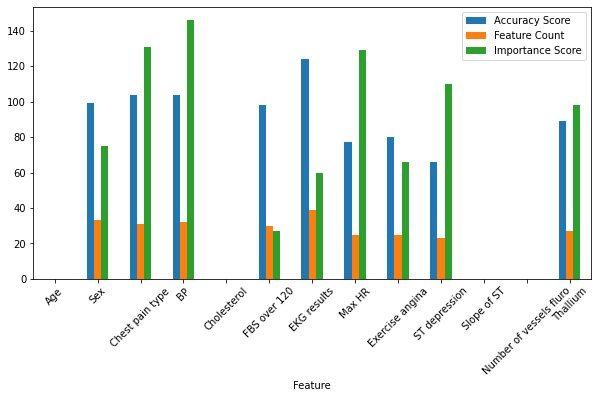

In [45]:
list(scores.keys())
data = []
for feature in scores.keys():
    data.append([feature, scores[feature]["accuracy_score"], scores[feature]["feature_appearance"], scores[feature]["importance_score"]])

plot_df = pd.DataFrame(data, columns=["Feature", "Accuracy Score", "Feature Count", "Importance Score"])
plot_df.plot(x="Feature", y=["Accuracy Score", "Feature Count", "Importance Score"], kind="bar",figsize=(10,5))
plt.xticks(rotation= 45)
plt.show()

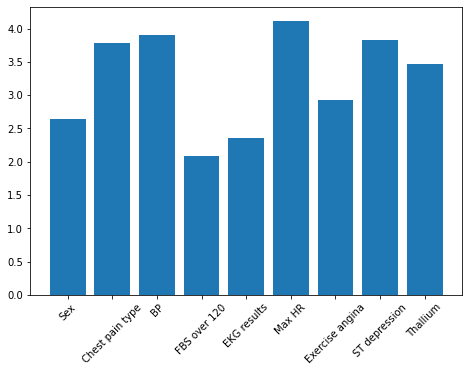

In [107]:
def get_final_score(feature):
    avg = ((scores[feature]["accuracy_score"] + scores[feature]["importance_score"]) / 2 )
    if avg != 0:
        result = avg / scores[feature]["feature_appearance"]
        return result

final_scores = []
final_labels = []
for feature in scores.keys():
    f_score = get_final_score(feature)
    if f_score != None:
        final_scores.append(f_score)
        final_labels.append(feature)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(final_labels, final_scores)
plt.xticks(rotation= 45)
plt.show()


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

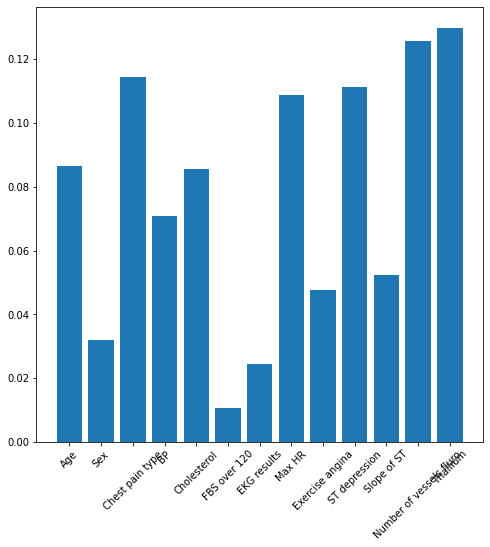

In [32]:
clf = RandomForestClassifier()
clf.fit(df_norm, y)
plt.figure(figsize=(8,8))
plt.bar(df_norm.columns, clf.feature_importances_)
plt.xticks(rotation=45)

In [1]:
# TODO: Select only the most important features (add treshold 0.05) (increase or decrease the treshold)
# IDEA: drop features and measuring how the given combination modifies (gets batter/worse)
# TODO set delta = set by the user, minimum differece between the two sets
# TODO Remove worst 30% of the features
# TODO Compare model accuracy, differences.
# TODO Plot the content of the model_counter
# TODO Add Cross Validation

# LATER: Export combinations and run the evaulation script on each of them in pararell

In [109]:
final_labels

['Sex',
 'Chest pain type',
 'BP',
 'FBS over 120',
 'EKG results',
 'Max HR',
 'Exercise angina',
 'ST depression',
 'Thallium']

[[0.03258444]
 [0.10057547]
 [0.10740589]
 [0.        ]
 [0.01624072]
 [0.12      ]
 [0.04929624]
 [0.1026827 ]
 [0.08128751]]


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

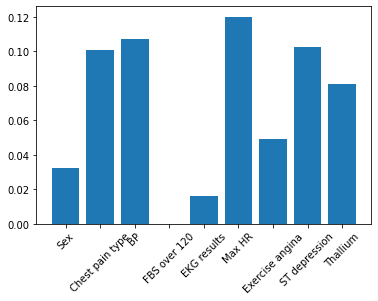

In [128]:
min_max_scaler = MinMaxScaler(feature_range=(0, 0.12))
final_scores = pd.DataFrame(final_scores).values.reshape(-1, 1)
final_scores = min_max_scaler.fit_transform(final_scores)
print(final_scores)
final_scores = np.concatenate( final_scores, axis=0 )
plt.bar(final_labels, final_scores)
plt.xticks(rotation=45)